Question: What is the average number of words in a Wikipedia article?


⏳ Collecting samples...



Sampling Progress:   0%|          | 0/10 [00:00<?, ?it/s]

Sample Means → Mean: 579.96, SE: 96.82, MOE: ±189.76, 95% CI: (390.20, 769.73)
Proportions → Mean p̂: 0.28, SE: 0.142, MOE: ±0.278, 95% CI: (0.00, 0.56)

📊 Preview of first 10 collected articles:


,Sample_ID,Title,Word_Count,Long_Article
0,1,John Baber (footballer),51,0
1,1,2010 British Columbia Scotties Tournament of H...,168,0
2,1,The Fortress (1979 film),102,0
3,1,Popeye (film),2608,1
4,1,Newfoundland and Labrador Rugby Union,59,0
5,1,Jean-Baptiste Blanchard (painter),287,0
6,1,Polsby–Popper test,255,0
7,1,Cultural influence of Holst's The Planets,1936,1
8,1,Baldomero Rubiera,33,0
9,1,Mangetsu-ji,141,0


📊 Sample Summary (Mean Word Count & Proportion of Long Articles):


,Sample_ID,Mean_Word_Count,Proportion_Long_Articles
0,1,465.95,0.15
1,2,1270.85,0.40
2,3,211.15,0.10
3,4,522.05,0.40
4,5,609.50,0.30
5,6,322.55,0.15
6,7,921.95,0.40
7,8,446.05,0.25
8,9,473.45,0.25
9,10,556.15,0.40


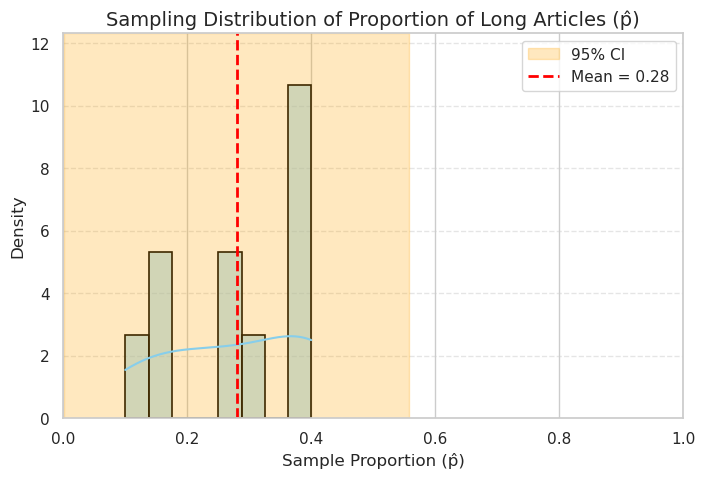

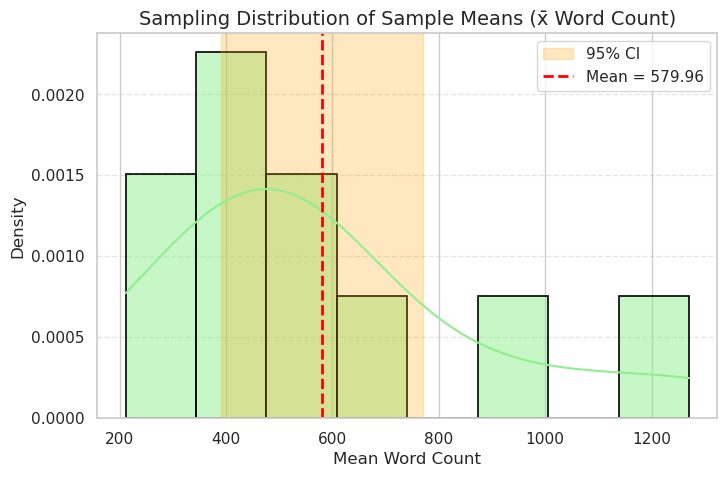

In [46]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import math
from tqdm.notebook import tqdm
import warnings
import numpy as np

# Settings

warnings.filterwarnings("ignore", category=FutureWarning)
sns.set(style="whitegrid")
sns.set_palette("pastel")

headers = {"User-Agent": "WikiConfidenceClassProject/1.0"}

ARTICLES_PER_SAMPLE = 20   # number of articles per sample
NUM_SAMPLES = 10           # number of samples
Z_SCORE = 1.96
TARGET_WORDS = 500         # threshold for long article

raw_records = []
sample_means = []
sample_proportions = []

# Function: Get random Wikipedia article word count

def get_random_article_wordcount(max_retries=3):
    url = "https://en.wikipedia.org/w/api.php"
    for _ in range(max_retries):
        try:
            # Random title
            params_title = {"action": "query","format": "json","list": "random","rnnamespace":0,"rnlimit":1}
            r_title = requests.get(url, params=params_title, headers=headers, timeout=5).json()
            title = r_title["query"]["random"][0]["title"]

            # Article text
            params_text = {"action":"query","format":"json","prop":"extracts","explaintext":True,"titles":title}
            r_text = requests.get(url, params=params_text, headers=headers, timeout=5).json()
            page = next(iter(r_text["query"]["pages"].values()))
            text = page.get("extract","")
            word_count = len(text.split())
            if word_count == 0:
                continue
            return word_count, title
        except:
            time.sleep(0.05)
            continue
    return None, None

# Collect samples

print("⏳ Collecting samples...\n")

for sample_id in tqdm(range(1, NUM_SAMPLES+1), desc="Sampling Progress", colour='green'):
    word_counts = []
    long_count = 0
    for _ in range(ARTICLES_PER_SAMPLE):
        wc, title = get_random_article_wordcount()
        if wc is None:
            continue
        word_counts.append(wc)
        if wc > TARGET_WORDS:
            long_count += 1
        raw_records.append({
            "Sample_ID": sample_id,
            "Title": title,
            "Word_Count": wc,
            "Long_Article": 1 if wc > TARGET_WORDS else 0
        })
    if len(word_counts) < ARTICLES_PER_SAMPLE:
        continue

    # Compute sample mean and proportion
    sample_mean = sum(word_counts)/ARTICLES_PER_SAMPLE
    sample_proportion = long_count/ARTICLES_PER_SAMPLE

    sample_means.append(sample_mean)
    sample_proportions.append(sample_proportion)

# DataFrames

df_raw = pd.DataFrame(raw_records)
df_means = pd.DataFrame(sample_means, columns=["sample_mean"])
df_proportions = pd.DataFrame(sample_proportions, columns=["p_hat"])

# Sample summary
df_sample_summary = pd.DataFrame({
    "Sample_ID": range(1, len(sample_means)+1),
    "Mean_Word_Count": sample_means,
    "Proportion_Long_Articles": sample_proportions
})

# Part 3: SE, MOE, 95% CI

# Sample Means
mean_word_count = df_means["sample_mean"].mean()
SE_means = df_means["sample_mean"].std()/math.sqrt(len(df_means))
MOE_means = Z_SCORE*SE_means
CI_lower_means = mean_word_count - MOE_means
CI_upper_means = mean_word_count + MOE_means

# Proportions
mean_phat = df_proportions["p_hat"].mean()
SE_phat = math.sqrt(mean_phat*(1-mean_phat)/len(df_proportions))
MOE_phat = Z_SCORE*SE_phat
CI_lower_phat = mean_phat - MOE_phat
CI_upper_phat = mean_phat + MOE_phat

# Display Results

print(f"Sample Means → Mean: {mean_word_count:.2f}, SE: {SE_means:.2f}, MOE: ±{MOE_means:.2f}, 95% CI: ({CI_lower_means:.2f}, {CI_upper_means:.2f})")
print(f"Proportions → Mean p̂: {mean_phat:.2f}, SE: {SE_phat:.3f}, MOE: ±{MOE_phat:.3f}, 95% CI: ({CI_lower_phat:.2f}, {CI_upper_phat:.2f})\n")

print("📊 Preview of first 10 collected articles:")
display(df_raw.head(10))

print("📊 Sample Summary (Mean Word Count & Proportion of Long Articles):")
display(df_sample_summary)

# Polished Visualization with KDE

# Histogram of proportions (p̂)
plt.figure(figsize=(8,5))
sns.histplot(df_proportions["p_hat"], bins=8, kde=True, stat="density",
             color="skyblue", edgecolor="black", linewidth=1.2)
plt.axvspan(CI_lower_phat, CI_upper_phat, color='orange', alpha=0.25, label="95% CI")
plt.axvline(mean_phat, color='red', linestyle='--', linewidth=2, label=f"Mean = {mean_phat:.2f}")
plt.title("Sampling Distribution of Proportion of Long Articles (p̂)", fontsize=14)
plt.xlabel("Sample Proportion (p̂)", fontsize=12)
plt.ylabel("Density", fontsize=12)
plt.xlim(0,1)
plt.ylim(0, plt.gca().get_ylim()[1]*1.1)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.legend()
plt.show()

# Histogram of sample means (x̄)
plt.figure(figsize=(8,5))
sns.histplot(df_means["sample_mean"], bins=8, kde=True, stat="density",
             color="lightgreen", edgecolor="black", linewidth=1.2)
plt.axvspan(CI_lower_means, CI_upper_means, color='orange', alpha=0.25, label="95% CI")
plt.axvline(mean_word_count, color='red', linestyle='--', linewidth=2, label=f"Mean = {mean_word_count:.2f}")
plt.title("Sampling Distribution of Sample Means (x̄ Word Count)", fontsize=14)
plt.xlabel("Mean Word Count", fontsize=12)
plt.ylabel("Density", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.legend()
plt.show()


Conclusion: Based on our sampling, a typical Wikipedia article contains approximately 580 words, with about 28% of articles exceeding 500 words.

Sample Mean and Distribution: Across 10 samples of 20 articles each, sample means ranged from 211 to 1,271 words, with an overall mean of 580 words. Despite variability in individual article lengths, the sample means show a clear central tendency.

Standard Error and Margin of Error: The standard error of the sample means is 96.82, resulting in a 95% confidence interval of 390 to 770 words, indicating we can be 95% confident that the true average article length falls within this range.

Proportion of Long Articles: On average, 28% of articles exceed 500 words, with a 95% confidence interval of 0% to 56%, highlighting that a notable portion of articles are long.

Graph Normality Considerations: While the sampling distributions of both means and proportions approximate a normal distribution, they are not perfectly symmetric due to the limited sample size and number of samples. Increasing the number of articles per sample, the number of samples, or filtering extreme outliers would make the distributions more closely resemble a normal curve.

Overall, these sampling distributions provide reliable quantitative evidence for the typical length of Wikipedia articles and the proportion of long articles, supporting the estimates above.